# Sentiment Analysis on Reddit Economic News Headlines

### What I did in this notebook is scripting news headlines on reddit, labeling each news as positive, negative or neutral, and check most frequent words in positive posts and negative posts.

### Next Steps: discovering the relationship between economic regimes and news labels using machine learning techniques

#### Reference: 
- https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
- https://pythonprogramming.net/introduction-python-reddit-api-wrapper-praw-tutorial/
- https://praw.readthedocs.io/en/latest/

In [45]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
# !pip install praw    #uncomment to install praw

In [47]:
import praw

reddit = praw.Reddit(client_id='WRjOfyqAsrBaFw',
                     client_secret='iLeL44R_ORjjyeq0OzT4Y3sU2zg',
                     user_agent='news script', username='news script')

# https://www.reddit.com/prefs/apps

In [49]:
# scripting the top 1000 submission titles and dates in the past year under 'economy' on https://www.reddit.com/r/economy/
# attributes of reddit.subreddit(): https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html

from datetime import datetime

headlines = []
for submission in reddit.subreddit('economy').top(time_filter='year',limit=None):
    headlines.append([submission.title, datetime.fromtimestamp(submission.created_utc).date()]) 
    display.clear_output()
    print(len(headlines))
    

1000


In [52]:
### sentiment analysis: labeling our data

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line[0])
    pol_score['headline'] = line[0]
    pol_score['date'] = line[1]
    results.append(pol_score)

pprint(results[:3], width=100)   # see some example outputs
# `compound` ranges from -1 (Extremely Negative) to 1 (Extremely Positive).

[{'compound': -0.1027,
  'date': datetime.date(2018, 11, 24),
  'headline': 'Another study shows Gender Pay Gap is really just a Gender Choice Gap',
  'neg': 0.113,
  'neu': 0.887,
  'pos': 0.0},
 {'compound': -0.1027,
  'date': datetime.date(2019, 1, 5),
  'headline': 'US national debt has increased $2 trillion since Trump took office',
  'neg': 0.184,
  'neu': 0.662,
  'pos': 0.154},
 {'compound': 0.0,
  'date': datetime.date(2019, 1, 21),
  'headline': 'Minnesota Becomes 5th State to Restrict Use of Monsanto Herbicide: States are '
              "standing up to protect us against Monsanto's new herbicide dicamba, since EPA won't",
  'neg': 0.092,
  'neu': 0.816,
  'pos': 0.092}]


In [53]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,date,headline,neg,neu,pos
0,-0.1027,2018-11-24,Another study shows Gender Pay Gap is really j...,0.113,0.887,0.000
1,-0.1027,2019-01-05,US national debt has increased $2 trillion sin...,0.184,0.662,0.154
2,0.0000,2019-01-21,Minnesota Becomes 5th State to Restrict Use of...,0.092,0.816,0.092
3,-0.1027,2018-08-23,"Bernie Sanders to Jeff Bezos, who earns $275 m...",0.091,0.909,0.000
4,-0.5106,2019-01-06,The astonishing thing is that we have clung to...,0.066,0.934,0.000


In [54]:
# We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative.

df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,date,headline,neg,neu,pos,label
0,-0.1027,2018-11-24,Another study shows Gender Pay Gap is really j...,0.113,0.887,0.000,0
1,-0.1027,2019-01-05,US national debt has increased $2 trillion sin...,0.184,0.662,0.154,0
2,0.0000,2019-01-21,Minnesota Becomes 5th State to Restrict Use of...,0.092,0.816,0.092,0
3,-0.1027,2018-08-23,"Bernie Sanders to Jeff Bezos, who earns $275 m...",0.091,0.909,0.000,0
4,-0.5106,2019-01-06,The astonishing thing is that we have clung to...,0.066,0.934,0.000,-1


-1    403
 0    353
 1    244
Name: label, dtype: int64


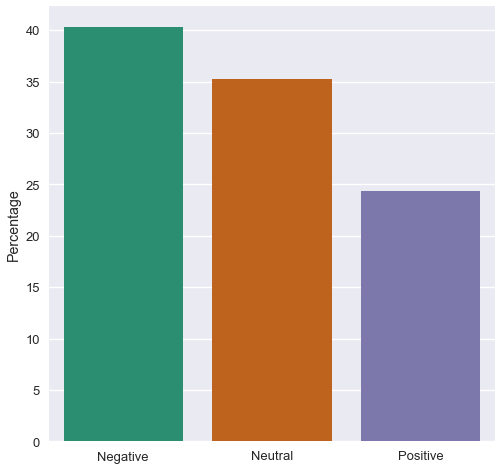

In [55]:
# check how many total positives and negatives we have in this dataset
print(df.label.value_counts())

fig, ax = plt.subplots(figsize=(8, 8))
counts = df.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

In [57]:
# save data to csv
df.to_csv('reddit_headline_label.csv', mode='a', encoding='utf-8', index=False)

In [10]:
### sentiment analysis: tokenizer and word frequency

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [11]:
# grab all positive label headlines from our dataframe, and get the most common words in the positive headlines
pos_lines = list(df[df.label == 1].headline)
pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20) # top 20 frequent words in positive words

[('trump', 42),
 ('us', 22),
 ('u', 22),
 ('tax', 21),
 ('america', 19),
 ('1', 19),
 ('rich', 19),
 ('wage', 18),
 ('growth', 18),
 ('states', 17),
 ('billion', 17),
 ('world', 16),
 ('percent', 15),
 ('says', 14),
 ('worth', 14),
 ('united', 13),
 ('wealth', 13),
 ('economy', 13),
 ('china', 13),
 ('workers', 12)]

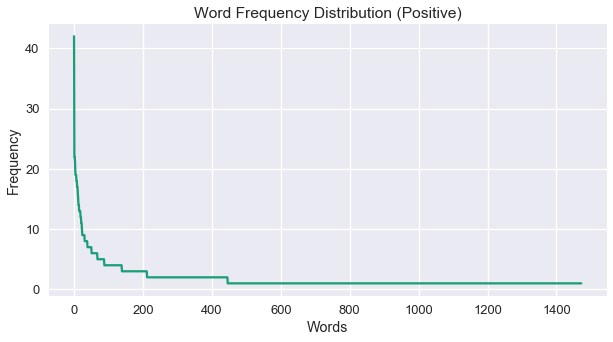

In [12]:
# plot the frequency distribution and try to examine the pattern of words and not each word specifically
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

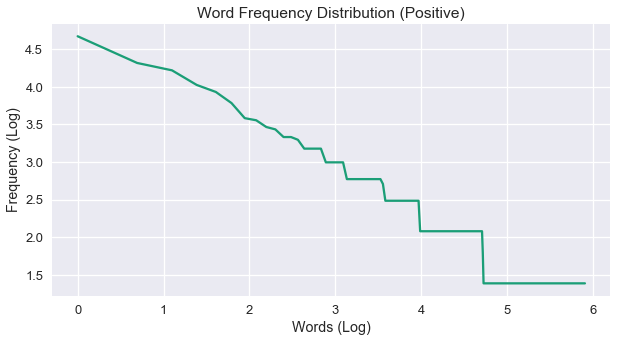

In [13]:
# we use a log-log plot to check if the word frequency follows power-law distribution (https://en.wikipedia.org/wiki/Power_law)
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [15]:
# do the same to see word frequency in negative posts
neg_lines = list(df[df.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20) # top 20 frequent words in negative posts

[('trump', 82),
 ('us', 63),
 ('debt', 47),
 ('trade', 41),
 ('u', 40),
 ('war', 30),
 ('america', 29),
 ('china', 29),
 ('economy', 28),
 ('new', 26),
 ('student', 26),
 ('tax', 24),
 ('says', 24),
 ('recession', 23),
 ('crisis', 22),
 ('americans', 22),
 ('tariffs', 21),
 ('trillion', 21),
 ('1', 20),
 ('could', 20)]

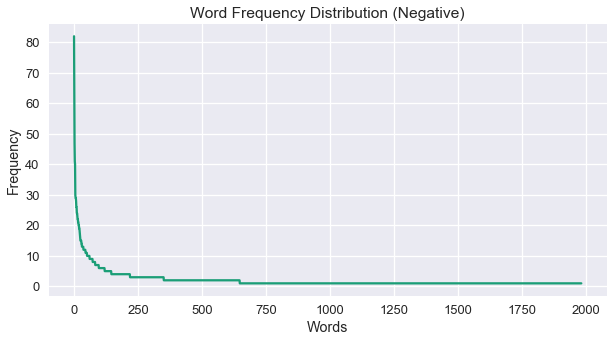

In [16]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

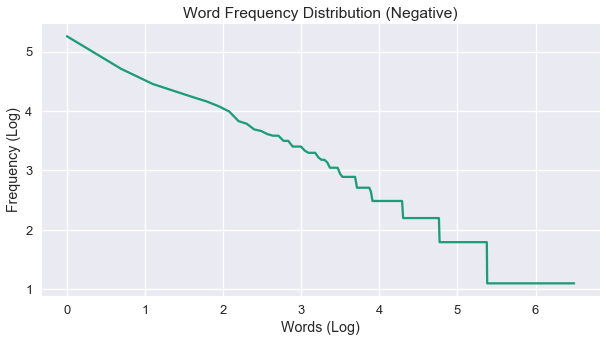

In [17]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

In [144]:
### relationship between news signals and sp500

# getting sp500 daily data from https://finance.yahoo.com/quote/%5EGSPC/history?period1=1532836800&period2=1564372800&interval=1d&filter=history&frequency=1d

import pandas as pd
sp = pd.read_csv('sp500.csv', sep=',')

# converting Date into datetime
for i in range(len(sp.Date)):
    sp.set_value(i, 'Date', datetime.strptime(sp.Date[i],'%Y-%m-%d').date())
sp.Date.unique()
sp.head()

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-30,2819.000000,2821.739990,2798.110107,2802.600098,2802.600098,3245770000
1,2018-07-31,2809.729980,2824.459961,2808.060059,2816.290039,2816.290039,3892100000
2,2018-08-01,2821.169922,2825.830078,2805.850098,2813.360107,2813.360107,3496990000
3,2018-08-02,2800.479980,2829.909912,2796.340088,2827.219971,2827.219971,3467380000
4,2018-08-03,2829.620117,2840.379883,2827.370117,2840.350098,2840.350098,3030390000


In [145]:
data = pd.merge(sp, df, how='left',left_on='Date', right_on='date')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound,date,headline,neg,neu,pos,label
0,2018-07-30,2819.0,2821.73999,2798.110107,2802.600098,2802.600098,3245770000,0.0000,2018-07-30,US housing market slowdown waves red flag for ...,0.000,1.000,0.000,0.0
1,2018-07-30,2819.0,2821.73999,2798.110107,2802.600098,2802.600098,3245770000,0.0000,2018-07-30,China is laying the groundwork for a post-Amer...,0.000,1.000,0.000,0.0
2,2018-07-30,2819.0,2821.73999,2798.110107,2802.600098,2802.600098,3245770000,0.1298,2018-07-30,Bernie Sanders’s $32 trillion Medicare-for-all...,0.000,0.869,0.131,0.0
3,2018-07-30,2819.0,2821.73999,2798.110107,2802.600098,2802.600098,3245770000,0.0000,2018-07-30,Should people be paid for their data?,0.000,1.000,0.000,0.0
4,2018-07-30,2819.0,2821.73999,2798.110107,2802.600098,2802.600098,3245770000,-0.1027,2018-07-30,Full-scale bailout for industries impacted by ...,0.091,0.909,0.000,0.0


In [146]:
data[['Close','compound']].corr()

,Close,compound
Close,1.000000,0.078293
compound,0.078293,1.000000


In [147]:
data[['Close','compound']].corr()

,Close,compound
Close,1.000000,0.078293
compound,0.078293,1.000000
